In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.gmm import GMM
from pyod.models.pca import PCA
from pyod.models.lof import LOF
from pyod.utils.utility import standardizer
from pyod.models.combination import average
from scipy.optimize import fsolve
from utils import *

In [2]:
data = pd.read_csv("airbnb_data/AB_US_2023.csv", low_memory=False) # .sample(frac=0.1, random_state=42)

In [3]:
cols_to_drop = ["id", "name", "host_id", "host_name", "neighbourhood_group",
                "neighbourhood", "latitude", "longitude", "room_type",
                "last_review", "number_of_reviews_ltm", "city"]

data.drop(cols_to_drop, axis=1, inplace=True)

In [4]:
data

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,202,2,383,2.31,1,128
1,235,30,111,0.66,1,365
2,56,32,9,0.09,13,365
3,575,9,28,0.17,2,365
4,110,1,770,4.65,2,159
...,...,...,...,...,...,...
232142,389,2,0,NaN,1,365
232143,158,1,0,NaN,1,364
232144,97,1,0,NaN,32,359
232145,62,2,0,NaN,3,67


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232147 entries, 0 to 232146
Data columns (total 6 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   price                           232147 non-null  int64  
 1   minimum_nights                  232147 non-null  int64  
 2   number_of_reviews               232147 non-null  int64  
 3   reviews_per_month               183062 non-null  float64
 4   calculated_host_listings_count  232147 non-null  int64  
 5   availability_365                232147 non-null  int64  
dtypes: float64(1), int64(5)
memory usage: 10.6 MB


In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
price,232147.0,259.468001,1024.645918,0.00,91.00,149.0,250.00,100000.00
minimum_nights,232147.0,13.495867,27.920631,1.00,2.00,3.0,30.00,1250.00
number_of_reviews,232147.0,40.915230,80.649152,0.00,1.00,9.0,43.00,3091.00
reviews_per_month,183062.0,1.638348,1.910812,0.01,0.31,1.0,2.42,101.42
calculated_host_listings_count,232147.0,29.879055,106.013665,1.00,1.00,2.0,10.00,1003.00
availability_365,232147.0,180.985686,134.715299,0.00,52.00,175.0,321.00,365.00


In [7]:
data["reviews_per_month"] = data["reviews_per_month"].fillna(0) 

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop("price", axis=1),
    data[["price"]],
    random_state=42)

In [9]:
# tsne = TSNE(random_state=42, n_jobs=-1)
# X_train_tsne = tsne.fit_transform(X_train)

In [10]:
# plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], s=0.6);

In [11]:
iforest = IForest(contamination=0.1, n_jobs=-1, random_state=42)
iforest.fit(X_train)

IForest(behaviour='old', bootstrap=False, contamination=0.1, max_features=1.0,
    max_samples='auto', n_estimators=100, n_jobs=-1, random_state=42,
    verbose=0)

In [12]:
gmm = GMM(contamination=0.1, n_components=1, random_state=42)
gmm.fit(X_train)

GMM(contamination=0.1, covariance_type='full', init_params='kmeans',
  max_iter=100, means_init=None, n_components=1, n_init=1,
  precisions_init=None, random_state=42, reg_covar=1e-06, tol=0.001,
  warm_start=False, weights_init=None)

In [13]:
lof = LOF(contamination=0.1, n_jobs=-1)
lof.fit(X_train)

LOF(algorithm='auto', contamination=0.1, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=-1, n_neighbors=20, novelty=True, p=2)

In [14]:
hbos = HBOS(contamination=0.1)
hbos.fit(X_train)

HBOS(alpha=0.1, contamination=0.1, n_bins=10, tol=0.5)

In [15]:
knn = KNN(contamination=0.1, n_jobs=-1)
knn.fit(X_train)

KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
  radius=1.0)

In [16]:
pca = PCA(contamination=0.1, n_components=1, random_state=42)
pca.fit(X_train)

PCA(contamination=0.1, copy=True, iterated_power='auto', n_components=1,
  n_selected_components=None, random_state=42, standardization=True,
  svd_solver='auto', tol=0.0, weighted=True, whiten=False)

In [17]:
train_pred_scores_iforest = iforest.decision_function(X_train.values).reshape(-1, 1)
train_pred_scores_gmm = gmm.decision_function(X_train.values).reshape(-1, 1)
train_pred_scores_lof = lof.decision_function(X_train.values).reshape(-1, 1)
train_pred_scores_hbos = hbos.decision_function(X_train.values).reshape(-1, 1)
train_pred_scores_knn = knn.decision_function(X_train.values).reshape(-1, 1)
train_pred_scores_pca = pca.decision_function(X_train.values).reshape(-1, 1)

test_pred_scores_iforest = iforest.decision_function(X_test.values).reshape(-1, 1)
test_pred_scores_gmm = gmm.decision_function(X_test.values).reshape(-1, 1)
test_pred_scores_lof = lof.decision_function(X_test.values).reshape(-1, 1)
test_pred_scores_hbos = hbos.decision_function(X_test.values).reshape(-1, 1)
test_pred_scores_knn = knn.decision_function(X_test.values).reshape(-1, 1)
test_pred_scores_pca = pca.decision_function(X_test.values).reshape(-1, 1)

In [18]:
# print(iforest.threshold_)
# plt.hist(train_pred_scores_iforest, bins='auto')
# plt.title("Outlier score");

In [19]:
# print(gmm.threshold_)
# plt.hist(train_pred_scores_gmm, bins='auto')
# plt.title("Outlier score");

In [20]:
# print(lof.threshold_)
# plt.hist(train_pred_scores_lof, bins='auto')
# plt.title("Outlier score");

In [21]:
features_list = X_train.columns

In [22]:
threshold_iforest = iforest.threshold_
print(threshold_iforest)
display(descriptive_stat_threshold(X_train, features_list, train_pred_scores_iforest, threshold_iforest).T)
display(descriptive_stat_threshold(X_test, features_list, test_pred_scores_iforest, threshold_iforest).T)

6.172202031699998e-17


,0,1
Group,Normal,Outlier
Count,156699,17411
Count %,90.0,10.0
minimum_nights,11.21,34.73
number_of_reviews,29.34,146.89
reviews_per_month,1.12,2.87
calculated_host_listings_count,12.07,189.26
availability_365,178.12,207.33
Anomaly_Score,-0.1,0.05


,0,1
Group,Normal,Outlier
Count,52190,5847
Count %,89.925392,10.074608
minimum_nights,11.12,32.7
number_of_reviews,28.81,143.66
reviews_per_month,1.12,2.84
calculated_host_listings_count,12.01,192.14
availability_365,177.86,207.32
Anomaly_Score,-0.1,0.05


In [23]:
threshold_gmm = gmm.threshold_
print(threshold_gmm)
display(descriptive_stat_threshold(X_train, features_list, train_pred_scores_gmm, threshold_gmm).T)
display(descriptive_stat_threshold(X_test, features_list, test_pred_scores_gmm, threshold_gmm).T)

25.881760104818404


,0,1
Group,Normal,Outlier
Count,156699,17411
Count %,90.0,10.0
minimum_nights,11.38,33.17
number_of_reviews,29.57,144.77
reviews_per_month,1.06,3.4
calculated_host_listings_count,14.62,166.29
availability_365,178.63,202.69
Anomaly_Score,23.3,37.41


,0,1
Group,Normal,Outlier
Count,52118,5919
Count %,89.801334,10.198666
minimum_nights,11.32,30.66
number_of_reviews,28.83,142.04
reviews_per_month,1.05,3.4
calculated_host_listings_count,14.55,167.58
availability_365,178.18,204.1
Anomaly_Score,23.3,35.53


In [24]:
threshold_lof = lof.threshold_
print(threshold_lof)
display(descriptive_stat_threshold(X_train, features_list, train_pred_scores_lof, threshold_lof).T)
display(descriptive_stat_threshold(X_test, features_list, test_pred_scores_lof, threshold_lof).T)

1.285801980966879


,0,1
Group,Normal,Outlier
Count,158152,15958
Count %,90.83453,9.16547
minimum_nights,12.28,26.29
number_of_reviews,41.76,34.44
reviews_per_month,1.3,1.23
calculated_host_listings_count,28.49,42.62
availability_365,184.75,144.3
Anomaly_Score,1.04,1493623369.99


,0,1
Group,Normal,Outlier
Count,52102,5935
Count %,89.773765,10.226235
minimum_nights,11.92,25.35
number_of_reviews,41.24,32.85
reviews_per_month,1.3,1.23
calculated_host_listings_count,28.56,44.22
availability_365,184.61,147.59
Anomaly_Score,1.04,1815244307.31


In [25]:
threshold_hbos = hbos.threshold_
print(threshold_hbos)
display(descriptive_stat_threshold(X_train, features_list, train_pred_scores_hbos, threshold_hbos).T)
display(descriptive_stat_threshold(X_test, features_list, test_pred_scores_hbos, threshold_hbos).T)

15.321686802766044


,0,1
Group,Normal,Outlier
Count,153729,20381
Count %,88.294182,11.705818
minimum_nights,11.47,29.34
number_of_reviews,36.55,75.36
reviews_per_month,1.26,1.55
calculated_host_listings_count,8.9,187.34
availability_365,175.66,221.58
Anomaly_Score,15.28,15.39


,0,1
Group,Normal,Outlier
Count,51253,6784
Count %,88.310905,11.689095
minimum_nights,11.35,27.97
number_of_reviews,35.9,74.25
reviews_per_month,1.26,1.52
calculated_host_listings_count,8.87,191.01
availability_365,175.53,220.81
Anomaly_Score,15.28,15.39


In [26]:
threshold_knn = knn.threshold_
print(threshold_knn)
display(descriptive_stat_threshold(X_train, features_list, train_pred_scores_knn, threshold_knn).T)
display(descriptive_stat_threshold(X_test, features_list, test_pred_scores_knn, threshold_knn).T)

6.158319572905702


,0,1
Group,Normal,Outlier
Count,159112,14998
Count %,91.385905,8.614095
minimum_nights,12.71,22.57
number_of_reviews,30.96,148.55
reviews_per_month,1.13,2.98
calculated_host_listings_count,28.53,43.1
availability_365,179.65,195.81
Anomaly_Score,2.0,11.68


,0,1
Group,Normal,Outlier
Count,52296,5741
Count %,90.108035,9.891965
minimum_nights,12.57,19.91
number_of_reviews,29.43,140.09
reviews_per_month,1.12,2.85
calculated_host_listings_count,28.48,45.42
availability_365,179.18,195.79
Anomaly_Score,2.09,11.46


In [27]:
threshold_pca = pca.threshold_
print(threshold_pca)
display(descriptive_stat_threshold(X_train, features_list, train_pred_scores_pca, threshold_pca).T)
display(descriptive_stat_threshold(X_test, features_list, test_pred_scores_pca, threshold_pca).T)

7.02707722113767


,0,1
Group,Normal,Outlier
Count,156699,17411
Count %,90.0,10.0
minimum_nights,10.67,39.63
number_of_reviews,32.34,119.89
reviews_per_month,1.17,2.39
calculated_host_listings_count,11.24,196.7
availability_365,177.63,211.71
Anomaly_Score,4.97,13.11


,0,1
Group,Normal,Outlier
Count,52159,5878
Count %,89.871978,10.128022
minimum_nights,10.59,37.33
number_of_reviews,31.66,117.73
reviews_per_month,1.17,2.39
calculated_host_listings_count,11.16,198.72
availability_365,177.31,211.98
Anomaly_Score,4.97,12.84


In [28]:
contamination = [0.01, 0.05, 0.1]
n_components = [1, 2, 3, 4, 5]
rmse_dict = {}

for c, k in product(contamination, n_components):
    model = GMM(contamination=c, n_components=k, random_state=42)
    model.fit(X_train)
    inliers = evaluate_outlier_classifier(model, data)
    rmse_dict[(c, k)] = evaluate_regressor(inliers)

In [29]:
dict(sorted(rmse_dict.items(), key=lambda item: item[1]))

{(0.1, 5): 197.613,
 (0.1, 1): 244.295,
 (0.05, 5): 251.147,
 (0.1, 2): 280.774,
 (0.05, 1): 282.252,
 (0.1, 3): 282.457,
 (0.05, 3): 297.925,
 (0.05, 4): 308.234,
 (0.05, 2): 308.454,
 (0.1, 4): 322.562,
 (0.01, 1): 336.072,
 (0.01, 4): 357.854,
 (0.01, 2): 406.77,
 (0.01, 3): 416.786,
 (0.01, 5): 437.832}

In [30]:
contamination = [0.01, 0.05, 0.1]
max_features = [0.6, 0.8, 1]
max_samples = [0.6, 0.8, 1]
n_estimators = [100, 200, 400]
rmse_dict = {}

for c, mf, ms, k in product(contamination, max_features, max_samples, n_estimators):
    model = IForest(contamination=c, max_features=mf, max_samples=ms, n_estimators=k, n_jobs=-1, random_state=42)
    model.fit(X_train)
    inliers = evaluate_outlier_classifier(model, data)
    rmse_dict[(c, mf, ms, k)] = evaluate_regressor(inliers)

In [31]:
dict(sorted(rmse_dict.items(), key=lambda item: item[1]))

{(0.1, 0.8, 0.6, 400): 242.109,
 (0.1, 0.8, 0.6, 100): 242.758,
 (0.1, 0.8, 0.8, 400): 248.374,
 (0.1, 0.6, 0.8, 400): 248.77,
 (0.1, 0.6, 0.6, 400): 248.884,
 (0.1, 0.8, 0.8, 100): 255.159,
 (0.1, 0.8, 0.6, 200): 268.129,
 (0.1, 0.8, 0.8, 200): 272.369,
 (0.1, 0.6, 0.6, 200): 279.618,
 (0.1, 0.6, 0.6, 100): 285.837,
 (0.05, 0.8, 0.6, 400): 288.211,
 (0.1, 0.6, 0.8, 200): 290.398,
 (0.05, 0.6, 0.6, 400): 297.59,
 (0.05, 0.8, 0.6, 100): 300.613,
 (0.05, 0.6, 0.8, 400): 300.725,
 (0.1, 1, 0.8, 400): 304.329,
 (0.1, 0.6, 0.8, 100): 305.977,
 (0.05, 0.8, 0.8, 400): 316.161,
 (0.05, 0.8, 0.8, 200): 319.723,
 (0.1, 1, 0.8, 100): 324.693,
 (0.05, 0.8, 0.6, 200): 325.282,
 (0.05, 0.6, 0.6, 100): 327.279,
 (0.05, 0.8, 0.8, 100): 327.517,
 (0.1, 1, 0.6, 400): 337.727,
 (0.05, 0.6, 0.6, 200): 339.268,
 (0.05, 0.6, 0.8, 200): 339.664,
 (0.1, 1, 0.6, 100): 339.941,
 (0.05, 0.6, 0.8, 100): 342.609,
 (0.05, 1, 0.6, 400): 348.413,
 (0.01, 0.6, 0.8, 400): 378.64,
 (0.01, 0.6, 0.6, 400): 382.589,
 (0.05

In [32]:
contamination = [0.01, 0.05, 0.1]
rmse_dict = {}

for c in contamination:
    model = LOF(contamination=c, n_jobs=-1)
    model.fit(X_train)
    inliers = evaluate_outlier_classifier(model, data)
    rmse_dict[c] = evaluate_regressor(inliers)

In [33]:
dict(sorted(rmse_dict.items(), key=lambda item: item[1]))

{0.1: 549.604, 0.05: 549.692, 0.01: 1060.83}

In [40]:
contamination = [0.01, 0.05, 0.1]
n_bins = [10, 20, 40, 80, 160]
rmse_dict = {}

for c, n in product(contamination, n_bins):
    model = HBOS(contamination=c, n_bins=n)
    model.fit(X_train)
    inliers = evaluate_outlier_classifier(model, data)
    rmse_dict[c] = evaluate_regressor(inliers)

In [41]:
dict(sorted(rmse_dict.items(), key=lambda item: item[1]))

{0.01: 898.205, 0.05: 1100.439, 0.1: 1191.384}

In [34]:
contamination = [0.01, 0.05, 0.1]
rmse_dict = {}

for c in contamination:
    model = KNN(contamination=c, n_jobs=-1)
    model.fit(X_train)
    inliers = evaluate_outlier_classifier(model, data)
    rmse_dict[c] = evaluate_regressor(inliers)

In [35]:
dict(sorted(rmse_dict.items(), key=lambda item: item[1]))

{0.01: 539.364, 0.1: 539.402, 0.05: 603.502}

In [36]:
contamination = [0.01, 0.05, 0.1]
n_components = [1, 2, 3, 4, 5]
rmse_dict = {}

for c, k in product(contamination, n_components):
    model = PCA(contamination=c, n_components=k, random_state=42)
    model.fit(X_train)
    inliers = evaluate_outlier_classifier(model, data)
    rmse_dict[(c, k)] = evaluate_regressor(inliers)

In [37]:
dict(sorted(rmse_dict.items(), key=lambda item: item[1]))

{(0.1, 1): 208.936,
 (0.1, 2): 223.716,
 (0.1, 5): 244.856,
 (0.1, 3): 247.782,
 (0.1, 4): 248.592,
 (0.05, 1): 264.666,
 (0.05, 2): 269.541,
 (0.05, 5): 279.466,
 (0.05, 4): 279.549,
 (0.05, 3): 290.919,
 (0.01, 1): 339.348,
 (0.01, 5): 345.997,
 (0.01, 2): 352.424,
 (0.01, 4): 353.013,
 (0.01, 3): 353.143}

In [42]:
gmm1 = GMM(contamination=0.1, n_components=5, random_state=42)
iforest1 = IForest(contamination=0.1, max_features=0.8, max_samples=0.6, n_estimators=400, n_jobs=-1, random_state=42)
iforest2 = IForest(contamination=0.1, max_features=0.8, max_samples=0.6, n_estimators=100, n_jobs=-1, random_state=42)
pca1 = PCA(contamination=0.1, n_components=1)
pca2 = PCA(contamination=0.1, n_components=2)

In [44]:
train_scores = np.zeros([len(X_train), 5])
test_scores = np.zeros([len(X_test), 5])
thresholds = np.zeros(5)
for i, clf in enumerate([gmm1, iforest1, iforest2, pca1, pca2]):
    clf.fit(X_train)
    thresholds[i] = clf.threshold_
    train_scores[:, i] = clf.decision_function(X_train.values)
    test_scores[:, i] = clf.decision_function(X_test.values)

In [51]:
thresholds

array([2.32732931e+01, 1.53959885e-17, 3.43687589e-17, 7.02707722e+00,
       1.83315115e+01])

In [45]:
train_means = train_scores.mean(axis=0)
train_stds = train_scores.std(axis=0)
threshold_final = np.mean((thresholds - train_means)/train_stds).item()

threshold_final

0.7431765101832182

In [46]:
train_scores_norm, test_scores_norm = standardizer(train_scores, test_scores)

In [47]:
y_train_by_average = average(train_scores_norm)
y_test_by_average = average(test_scores_norm)

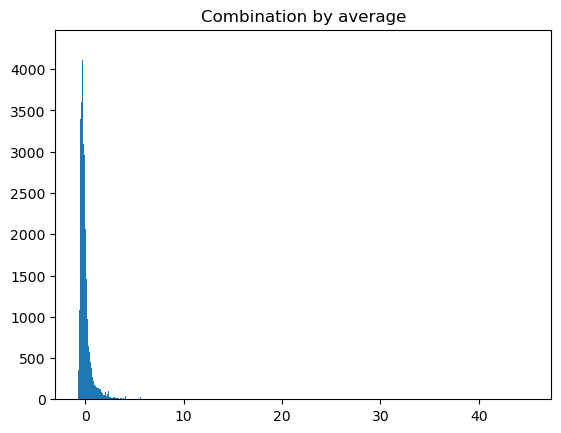

In [48]:
plt.hist(y_train_by_average, bins='auto')
plt.title("Combination by average")
plt.show()

In [168]:
def compute_contamination(threshold):
    df = pd.DataFrame()
    df['Anomaly_Score'] = y_train_by_average
    df['Group'] = np.where(df['Anomaly_Score'] < threshold.item(), 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score': 'Count'})
    outlier_pct = (cnt['Count'] / cnt['Count'].sum()).tolist()[-1]
    return 0.1 - outlier_pct

In [174]:
threshold_final = fsolve(compute_contamination, x0=0).item()

In [175]:
descriptive_stat_threshold(X_train, features_list, y_train_by_average, threshold_final).T

,0,1
Group,Normal,Outlier
Count,156699,17411
Count %,90.0,10.0
minimum_nights,11.36,33.41
number_of_reviews,30.5,136.46
reviews_per_month,1.11,2.9
calculated_host_listings_count,11.67,192.8
availability_365,178.1,207.5
Anomaly_Score,-0.19,1.72


In [176]:
descriptive_stat_threshold(X_test, features_list, y_test_by_average, threshold_final).T

,0,1
Group,Normal,Outlier
Count,52126,5911
Count %,89.815118,10.184882
minimum_nights,11.27,31.17
number_of_reviews,29.81,133.59
reviews_per_month,1.11,2.89
calculated_host_listings_count,11.6,193.81
availability_365,177.78,207.68
Anomaly_Score,-0.19,1.67
